In [1]:
import hdf5_getters
import numpy as np
import pandas as pd
import os
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

In [73]:
tt = pd.read_csv('../data/train_triplets.txt',delimiter='\t', header=None)
tt.columns = ['user_id', 'track_id','plays']

In [3]:
tt.head()

,user_id,track_id,plays
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


In [4]:
tt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48373586 entries, 0 to 48373585
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   user_id   object
 1   track_id  object
 2   plays     int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ GB


In [5]:
print(tt.plays[tt.plays > 100].shape[0]/tt.plays.shape[0])
tt.describe(percentiles = [.5, .75, .9, .95, .99])

0.00038886924777501504


,plays
count,4.837359e+07
mean,2.866859e+00
std,6.437725e+00
min,1.000000e+00
50%,1.000000e+00
75%,3.000000e+00
90%,6.000000e+00
95%,1.000000e+01
99%,2.400000e+01
max,9.667000e+03


In [6]:
num_users = tt.user_id.unique().shape[0]
num_songs = tt.track_id.unique().shape[0]
num_entries = tt.shape[0]
sparsity = num_entries/(num_users*num_songs)*100
print(sparsity)

0.012340998279304207


3.985291718592888


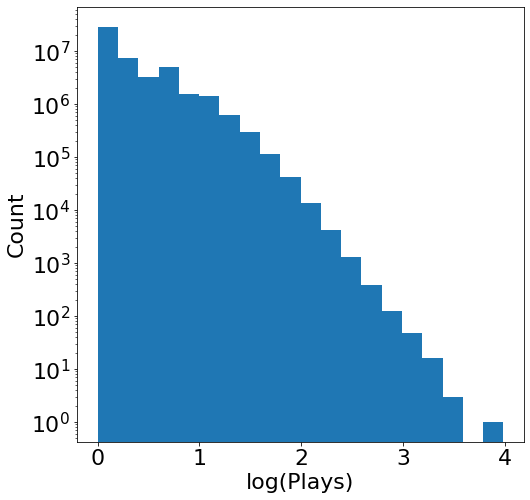

In [7]:
rcParams.update({'font.size': 22})

fig,ax = plt.subplots(figsize=(8,8))
ax.hist(np.log10(tt.plays),bins = 20,color = sns.color_palette("husl", 7)[1]);
plt.xlabel('log(Plays)')
plt.ylabel('Count')
print(np.max(np.log10(tt['plays'])))

plt.savefig('../img/plays_hist_logy.jpg')

In [8]:
tt.plays = tt.plays.transform(lambda x: 24 if x > 24 else x)
max_log_plays = np.max(np.log10(tt['plays']))
tt['rating'] = np.log10(tt.plays)/max_log_plays
tt = tt.drop(columns='plays')
tt.head()

,user_id,track_id,rating
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,0.000000
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,0.000000
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,0.218104
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,0.000000
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,0.000000


In [9]:
tt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48373586 entries, 0 to 48373585
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   object 
 1   track_id  object 
 2   rating    float64
dtypes: float64(1), object(2)
memory usage: 1.1+ GB


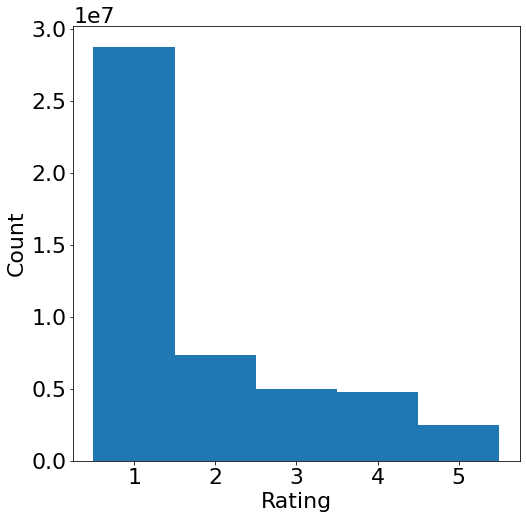

In [10]:
fig,ax = plt.subplots(figsize=(8,8))
ax.hist(round(tt.rating*5)+1,bins = 5,align='left',color = sns.color_palette("husl", 7)[2]);
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('../img/ratings_hist.jpg')
# print(np.max(tt['rating'])))

In [11]:
tt.shape

(48373586, 3)

In [12]:
tt.groupby('user_id').count()['track_id'].mean()

47.45681524313316

In [13]:
tt.groupby('track_id').count()['user_id'].mean()

125.79401684063805

In [51]:
track_popularity = tt.groupby('track_id').count()['user_id'].sort_values(ascending=False)
cumsum_popularity = np.cumsum(track_popularity/tt.shape[0])

In [19]:
track_popularity.head()

track_id
SOFRQTD12A81C233C0    110479
SOAUWYT12A81C206F1     90476
SOAXGDH12A8C13F8A1     90444
SOBONKR12A58A7A7E0     84000
SOSXLTC12AF72A7F54     80656
Name: user_id, dtype: int64

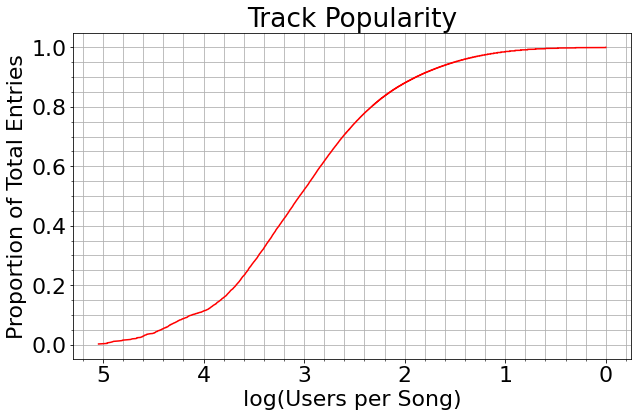

In [44]:
fig,ax = plt.subplots(figsize=(10,6))

#plot the survival function
ax.plot(np.log10(track_popularity),cumsum_popularity, 
        color = sns.color_palette("husl", 7)[0], linewidth=3)

ax.set_xlim(ax.get_xlim()[::-1])
plt.grid(which='both')
plt.minorticks_on()

plt.xlabel('log(Users per Song)')
plt.ylabel('Proportion of Total Entries')

plt.title('Track Popularity')
plt.savefig('../img/track_popularity.jpg')

In [36]:
track_popularity.describe(percentiles = [.25, .5, .75, .9, .95, .99])

count    384546.000000
mean        125.794017
std         799.025834
min           1.000000
25%           4.000000
50%          13.000000
75%          52.000000
90%         218.000000
95%         488.000000
99%        1970.000000
max      110479.000000
Name: user_id, dtype: float64

In [48]:
tt['track_id'].value_counts()[:500]

SOFRQTD12A81C233C0    110479
SOAUWYT12A81C206F1     90476
SOAXGDH12A8C13F8A1     90444
SOBONKR12A58A7A7E0     84000
SOSXLTC12AF72A7F54     80656
                       ...  
SOSBKKN12A8C1384B4      6565
SOCPTWE12A6701E2F8      6558
SOOHCUB12A58A7AD2C      6556
SOOEEPE12A8AE459A4      6556
SOTEFFR12A8C144765      6555
Name: track_id, Length: 500, dtype: int64

In [74]:
top_tracks = tt['track_id'].value_counts()[:250].index.tolist()
tt_top_tracks = tt[tt['track_id'].isin(top_tracks)]

num_users = tt_top_tracks.user_id.unique().shape[0]
num_songs = tt_top_tracks.track_id.unique().shape[0]
num_entries = tt_top_tracks.shape[0]
sparsity = num_entries/(num_users*num_songs)*100

print(sparsity)
print(tt_top_tracks.shape[0]/tt.shape[0])

tt_top_tracks.info()

2.8171851369450938
0.11446565073757402
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5537114 entries, 9 to 48373583
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   user_id   object
 1   track_id  object
 2   plays     int64 
dtypes: int64(1), object(2)
memory usage: 169.0+ MB


In [17]:
top_tracks = tt['track_id'].value_counts()[:100].index.tolist()
tt = tt[tt['track_id'].isin(top_tracks)]
tt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3431406 entries, 22 to 48373583
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   object 
 1   track_id  object 
 2   rating    float64
dtypes: float64(1), object(2)
memory usage: 104.7+ MB


In [18]:
tt['track_id'].value_counts()

SOFRQTD12A81C233C0    110479
SOAUWYT12A81C206F1     90476
SOAXGDH12A8C13F8A1     90444
SOBONKR12A58A7A7E0     84000
SOSXLTC12AF72A7F54     80656
                       ...  
SOKOXWU12AF72AD1BC     20555
SOGCWUH12AC90732B0     20439
SORJICW12A8C13640D     20404
SODCNJX12A6D4F93CB     20278
SOISNSU12AC468C0D8     20197
Name: track_id, Length: 100, dtype: int64

In [19]:
tt['rating'].mean()

0.1625454590083587

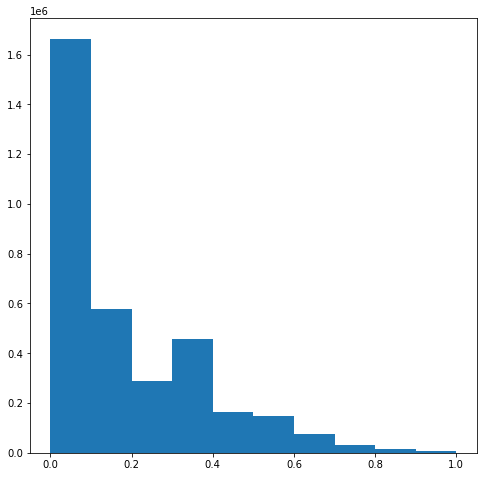

In [20]:
fig,ax = plt.subplots(figsize=(8,8))
ax.hist(tt['rating'],bins = 10);

In [21]:
tt['rating'].describe(percentiles = [.01, .05, .1, .25, .5, .75, .9, .95, .99])

count    3.431406e+06
mean     1.625455e-01
std      1.989782e-01
min      0.000000e+00
1%       0.000000e+00
5%       0.000000e+00
10%      0.000000e+00
25%      0.000000e+00
50%      1.505150e-01
75%      3.010300e-01
90%      4.515450e-01
95%      5.569717e-01
99%      7.592570e-01
max      1.000000e+00
Name: rating, dtype: float64

In [22]:
num_users = tt.user_id.unique().shape[0]
num_songs = tt.track_id.unique().shape[0]
num_entries = tt.shape[0]
sparsity = num_entries/(num_users*num_songs)*100
print(sparsity)

5.140583029843613


In [64]:
user_ubiquity = tt.groupby('user_id').count()['track_id'].sort_values(ascending=False)
cumsum_user = np.cumsum(user_ubiquity)

In [65]:
cumsum_user.head()

user_id
ec6dfcf19485cb011e0b22637075037aae34cf26     4400
8cb51abc6bf8ea29341cb070fe1e1af5e4c3ffcc     6051
fef771ab021c200187a419f5e55311390f850a50     7665
5a3417a1955d9136413e0d293cd36497f5e00238     9269
c1255748c06ee3f6440c51c439446886c7807095    10835
Name: track_id, dtype: int64

Text(0, 0.5, 'Proportion of Total Entries')

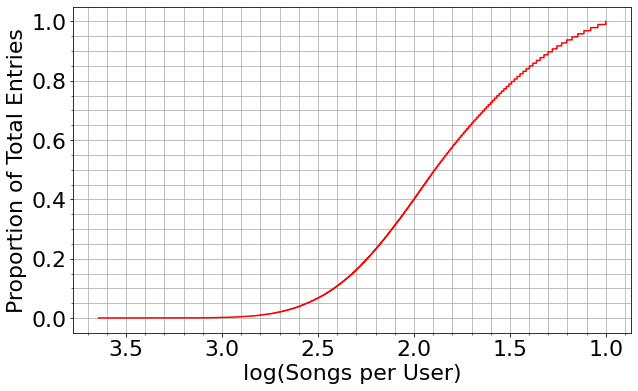

In [66]:
fig,ax = plt.subplots(figsize=(10,6))

#plot the survival function
ax.plot(np.log10(user_ubiquity),cumsum_user/tt.shape[0], c='red')

ax.set_xlim(ax.get_xlim()[::-1])
plt.grid(which='both')
plt.minorticks_on()

plt.xlabel('log(Songs per User)')
plt.ylabel('Proportion of Total Entries')

# plt.title('User Popularity')
# plt.savefig('../img/track_popularity.jpg')

In [67]:
user_ubiquity.describe(percentiles = [.25, .5, .75, .9, .95, .99])

count    1.019318e+06
mean     4.745682e+01
std      5.781573e+01
min      1.000000e+01
25%      1.600000e+01
50%      2.700000e+01
75%      5.500000e+01
90%      1.050000e+02
95%      1.500000e+02
99%      2.840000e+02
max      4.400000e+03
Name: track_id, dtype: float64

In [68]:
tt['user_id'].value_counts()[:500]

ec6dfcf19485cb011e0b22637075037aae34cf26    4400
8cb51abc6bf8ea29341cb070fe1e1af5e4c3ffcc    1651
fef771ab021c200187a419f5e55311390f850a50    1614
5a3417a1955d9136413e0d293cd36497f5e00238    1604
c1255748c06ee3f6440c51c439446886c7807095    1566
                                            ... 
fe685c55b08f504006a0c3aff077863837498481     654
0afa6b5d654f1817a421846d5a282d7397b6de42     654
1d3a9fdc4ae7ce0e9b8b7a26854cf193e13fe998     654
1d323510375f5bfeaebbcb47f941245236dc670e     654
14512336133dbf7022efda8a4a696d2cf165fc9d     653
Name: user_id, Length: 500, dtype: int64

In [71]:
top_users = tt['user_id'].value_counts()[:500].index.tolist()
tt_top_users = tt[tt['user_id'].isin(top_users)]

num_users = tt_top_users.user_id.unique().shape[0]
num_songs = tt_top_users.track_id.unique().shape[0]
num_entries = tt_top_users.shape[0]
sparsity = num_entries/(num_users*num_songs)*100

print(sparsity)
print(tt_top_users.shape[0]/tt.shape[0])

tt_top_users.info()

0.8115669079708865
0.008551774515951743
<class 'pandas.core.frame.DataFrame'>
Int64Index: 413680 entries, 43680 to 48323403
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   413680 non-null  object 
 1   track_id  413680 non-null  object 
 2   rating    413680 non-null  float64
dtypes: float64(1), object(2)
memory usage: 12.6+ MB


In [17]:
top_users = tt['user_id'].value_counts()[:100].index.tolist()
tt = tt[tt['track_id'].isin(top_tracks)]
tt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3431406 entries, 22 to 48373583
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   object 
 1   track_id  object 
 2   rating    float64
dtypes: float64(1), object(2)
memory usage: 104.7+ MB


In [18]:
tt['track_id'].value_counts()

SOFRQTD12A81C233C0    110479
SOAUWYT12A81C206F1     90476
SOAXGDH12A8C13F8A1     90444
SOBONKR12A58A7A7E0     84000
SOSXLTC12AF72A7F54     80656
                       ...  
SOKOXWU12AF72AD1BC     20555
SOGCWUH12AC90732B0     20439
SORJICW12A8C13640D     20404
SODCNJX12A6D4F93CB     20278
SOISNSU12AC468C0D8     20197
Name: track_id, Length: 100, dtype: int64